In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os
import math
import matplotlib.pyplot as plt
import diff_gaussian_rasterization_batched as dgrb

In [2]:
device = torch.device("cuda")

In [3]:
def gen_orthographic_matrix(
    left: float, right: float, bottom: float, top: float, near: float, far: float
):
    """Generate orthographic projection matrix.

    Args:
        left (float): left plane
        right (float): right plane
        bottom (float): bottom plane
        top (float): top plane
        near (float): near plane
        far (float): far plane

    Returns:
        torch.Tensor: orthographic projection matrix
    """
    return torch.tensor(
        [
            [2 / (right - left), 0, 0, -(right + left) / (right - left)],
            [0, 2 / (top - bottom), 0, -(top + bottom) / (top - bottom)],
            [0, 0, -2 / (far - near), -(far + near) / (far - near)],
            [0, 0, 0, 1],
        ]
    )


# predicts a set of gaussians that accurately represent an input image
class GaussianPredictor(nn.Module):
    def __init__(self, n_gaussians=16):
        super().__init__()
        self.n_gaussians = n_gaussians
        # 64x64 -> 32x32
        self.conv1 = nn.Conv2d(1, 32, 3, stride=2, padding=1)
        self.conv1_bn = nn.BatchNorm2d(32)
        # 32x32 -> 16x16
        self.conv2 = nn.Conv2d(32, 64, 3, stride=2, padding=1)
        self.conv2_bn = nn.BatchNorm2d(64)
        # 16x16 -> 8x8
        self.conv3 = nn.Conv2d(64, 128, 3, stride=2, padding=1)
        self.conv3_bn = nn.BatchNorm2d(128)
        self.fc1 = nn.Linear(128 * 8 * 8, 1024)
        self.fc2 = nn.Linear(1024, n_gaussians*6) # [x, y, sx, sy, r, o] * n_gaussians

        FoVx = 90
        FoVy = 90

        raster_settings = dgrb.GaussianRasterizationSettings(
            image_channels=1,
            image_height=64,
            image_width=64,
            tanfovx=math.tan(FoVx * 0.5),
            tanfovy=math.tan(FoVy * 0.5),
            bg=torch.zeros(1, dtype=torch.float32, device=device),
            scale_modifier=1.0,
            projmatrix=gen_orthographic_matrix(-1, 1, -1, 1, -1, 1).to(device),
            sh_degree=1,
            campos=torch.tensor([0, 0, 0], dtype=torch.float32, device=device),
            prefiltered=False,
            debug=False,
        )

        self.rasterizer = dgrb.GaussianRasterizer(
            raster_settings=raster_settings
        )

    def render_images_batch(
        self,
        # [B, N, 2]
        means: torch.Tensor,
        # [B, N, 2]
        scales: torch.Tensor,
        # [B, N, 1]
        rotations: torch.Tensor,
        # [B, N, 1]
        opacities: torch.Tensor,
    ) -> torch.Tensor:
        B, N = means.shape[:2]
        assert N >= 0
        assert means.shape == (B, N, 2)
        assert scales.shape == (B, N, 2)
        assert rotations.shape == (B, N, 1)
        assert opacities.shape == (B, N, 1)

        means3D = torch.cat(
            [means, torch.ones(B, N, 1, dtype=torch.float32, device=device)], dim=-1
        )
        means2D = torch.zeros(B, N, 3, dtype=torch.float32, device=device)
        scales = torch.cat(
            [scales, torch.zeros(B, N, 1, dtype=torch.float32, device=device)], dim=-1
        )
        quaternions = torch.cat(
            [
                torch.cos(rotations / 2),
                torch.zeros(B, N, 1, dtype=torch.float32, device=device),
                torch.zeros(B, N, 1, dtype=torch.float32, device=device),
                torch.sin(rotations / 2),
            ],
            dim=-1,
        )
        colors_precomp = torch.ones(B, N, 1, dtype=torch.float32, device=device)

        # [B, 1, H, W]
        rendered_image, _ = self.rasterizer(
                means3D=means3D,
                means2D=means2D,
                colors_precomp=colors_precomp,
                opacities=opacities,
                scales=scales,
                rotations=quaternions,
                viewmatrixes=torch.eye(4, dtype=torch.float32, device=device).expand(B, 4, 4),
            )

        return rendered_image

    def predict_gaussians(self, x):
        # x: B x 1 x 64 x 64
        x = F.relu(self.conv1_bn(self.conv1(x)))
        x = F.relu(self.conv2_bn(self.conv2(x)))
        x = F.relu(self.conv3_bn(self.conv3(x)))
        x = x.flatten(start_dim=1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.view(-1, self.n_gaussians, 6)
        return x
    
    def forward(self, x):
        gaussian_preds = self.predict_gaussians(x)

        means_batched = torch.tanh(gaussian_preds[:, :, :2])
        scales_batched = torch.sigmoid(gaussian_preds[:, :, 2:4])
        rotations_batched = torch.sigmoid(gaussian_preds[:, :, 4:5])*math.pi*0.5
        opacities_batched = torch.sigmoid(gaussian_preds[:, :, 5:])
        rasterized_pred = self.render_images_batch(means_batched, scales_batched, rotations_batched, opacities_batched)

        return rasterized_pred

In [4]:
class GaussianPredictorArray(nn.Module):
    def __init__(self, in_channel:int, n_gaussians:int=16):
        super().__init__()
        self.in_channel = in_channel
        self.n_gaussians = n_gaussians
        self.predictors = nn.ModuleList([GaussianPredictor(n_gaussians) for _ in range(in_channel)])

    def forward(self, x):
        # x has shape B x C x 64 x 64
        assert x.shape[1] == self.in_channel
        preds = []
        for i in range(self.in_channel):
            preds.append(self.predictors[i](x[:, i, :, :].unsqueeze(1)))
        return torch.cat(preds, dim=1).mean(dim=1, keepdim=True)


class GaussianPredictorMultiChannel(nn.Module):
    def __init__(self, in_channel:int, out_channel:int, n_gaussians:int=16):
        super().__init__()
        self.in_channel = in_channel
        self.out_channel = out_channel
        self.n_gaussians = n_gaussians
        self.predictors = nn.ModuleList([GaussianPredictorArray(in_channel=in_channel, n_gaussians=n_gaussians) for _ in range(out_channel)])

    def forward(self, x):
        # x has shape B x C x 64 x 64
        preds = []
        for i in range(self.out_channel):
            preds.append(self.predictors[i](x))
        return torch.cat(preds, dim=1)


class GaussianBasedModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.gaussian_predictor_mc_1 = GaussianPredictorMultiChannel(in_channel=1, out_channel=2)
        self.gaussian_predictor_mc_2 = GaussianPredictorMultiChannel(in_channel=2, out_channel=4)
        self.conv1 = nn.Conv2d(4, 32, 3, stride=2, padding=1)
        self.conv1_bn = nn.BatchNorm2d(32)
        self.maxpool = nn.MaxPool2d(4)
        self.fc1 = nn.Linear(32 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.gaussian_predictor_mc_1(x)
        x = self.gaussian_predictor_mc_2(x)
        x = F.relu(self.conv1_bn(self.conv1(x)))
        x = self.maxpool(x)
        x = x.flatten(start_dim=1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [5]:
def train_gaussian_based_model(
    model: GaussianBasedModel,
    optim: torch.optim.Optimizer,
    images: torch.Tensor,
    labels: torch.Tensor,
) -> float:
    model.train()

    images = images.to(device)
    labels = labels.to(device)

    # predict gaussians
    predictions = model(images)

    # compute loss
    loss = F.cross_entropy(predictions, labels)

    # step loss
    optim.zero_grad()
    loss.backward()
    optim.step()

    return loss.item()

In [6]:
class ConvBasedModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.gaussian_predictor_mc_1 = nn.Conv2d(1, 2, stride=1, kernel_size=3, padding=1)
        self.gaussian_predictor_mc_2 = nn.Conv2d(2, 4, stride=1, kernel_size=3, padding=1)
        self.conv1 = nn.Conv2d(4, 32, 3, stride=2, padding=1)
        self.conv1_bn = nn.BatchNorm2d(32)
        self.maxpool = nn.MaxPool2d(4)
        self.fc1 = nn.Linear(32 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.gaussian_predictor_mc_1(x)
        x = self.gaussian_predictor_mc_2(x)
        x = F.relu(self.conv1_bn(self.conv1(x)))
        x = self.maxpool(x)
        x = x.flatten(start_dim=1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    

def train_conv_based_model(
    model: ConvBasedModel,
    optim: torch.optim.Optimizer,
    images: torch.Tensor,
    labels: torch.Tensor,
) -> float:
    model.train()

    images = images.to(device)
    labels = labels.to(device)

    # predict gaussians
    predictions = model(images)

    # compute loss
    loss = F.cross_entropy(predictions, labels)

    # step loss
    optim.zero_grad()
    loss.backward()
    optim.step()

    return loss.item()


In [7]:
# download mnist dataset
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

trainset = datasets.MNIST('data', download=True, train=True, transform=transform)
testset = datasets.MNIST('data', download=True, train=False, transform=transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)

# create model
gaussian_model = GaussianBasedModel().to(device)
gaussian_optim = torch.optim.Adam(gaussian_model.parameters(), lr=1e-5)

conv_model = ConvBasedModel().to(device)
conv_optim = torch.optim.Adam(conv_model.parameters(), lr=1e-5)

gaussian_losses = []
conv_losses = []

In [8]:
# train conv2d model
for epoch in range(3):
    print(f"Epoch {epoch}")
    for i, (images, labels) in enumerate(tqdm(trainloader)):
        loss = train_conv_based_model(conv_model, conv_optim, images, labels)
        conv_losses.append(loss)
    print(f"Loss: {loss}")

Epoch 0


100%|██████████| 938/938 [00:14<00:00, 65.18it/s]


Loss: 0.36571961641311646
Epoch 1


100%|██████████| 938/938 [00:14<00:00, 66.19it/s]


Loss: 0.4520820677280426
Epoch 2


100%|██████████| 938/938 [00:14<00:00, 63.02it/s]

Loss: 0.3801630139350891


In [9]:
# train gaussian model
for epoch in range(3):
    print(f"Epoch {epoch}")
    for i, (images, labels) in enumerate(tqdm(trainloader)):
        loss = train_gaussian_based_model(gaussian_model, gaussian_optim, images, labels)
        gaussian_losses.append(loss)
    print(f"Loss: {loss}")

Epoch 0


100%|██████████| 938/938 [03:54<00:00,  4.01it/s]


Loss: 0.05954877659678459
Epoch 1


100%|██████████| 938/938 [02:35<00:00,  6.05it/s]


Loss: 0.2723326086997986
Epoch 2


100%|██████████| 938/938 [02:34<00:00,  6.07it/s]

Loss: 0.039701711386442184


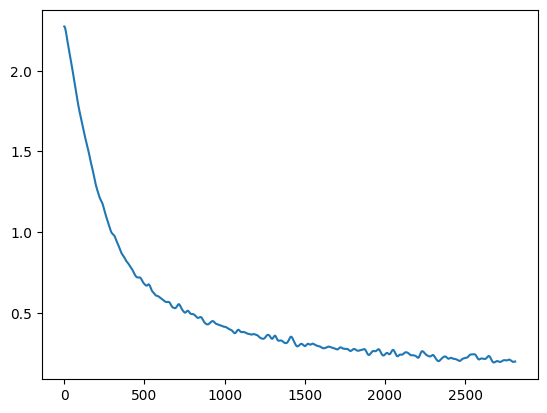

In [15]:
from scipy.ndimage import gaussian_filter

losses_smoothed = gaussian_filter(conv_losses, sigma=10)

plt.plot(losses_smoothed)

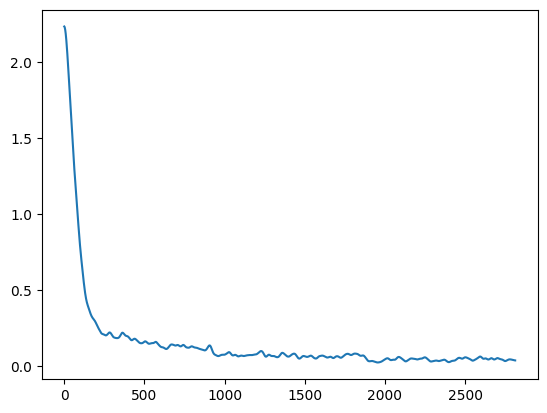

In [10]:
from scipy.ndimage import gaussian_filter

losses_smoothed = gaussian_filter(gaussian_losses, sigma=10)

plt.plot(losses_smoothed)

torch.Size([10, 1, 64, 64])
torch.Size([10, 2, 64, 64])
torch.Size([10, 4, 64, 64])


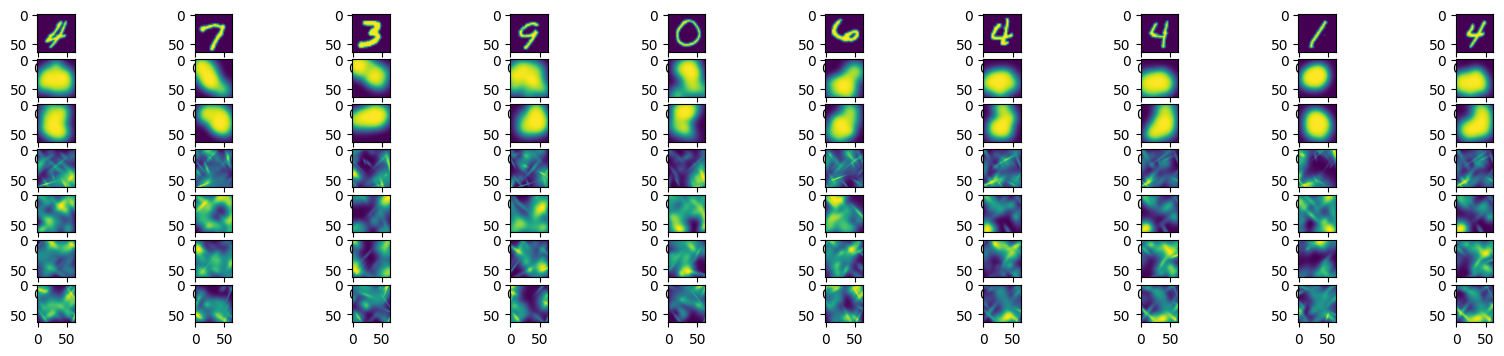

In [12]:
N_EXAMPLES = 10

trainloader_2 = DataLoader(testset, batch_size=N_EXAMPLES, shuffle=True)
images = next(iter(trainloader_2))[0]
print(images.shape)

images = images.to(device)

# predict gaussians
rasterized_pred_1 = gaussian_model.gaussian_predictor_mc_1(images)
rasterized_pred_2 = gaussian_model.gaussian_predictor_mc_2(rasterized_pred_1)

print(rasterized_pred_1.shape)
print(rasterized_pred_2.shape)

# create a plot comparing the original image to the rasterized image
fig, axs = plt.subplots(7, N_EXAMPLES, figsize=(20, 4))
for i in range(10):
    # input image
    axs[0, i].imshow(images[i].cpu().detach().numpy().squeeze())
    # first rasterization
    axs[1, i].imshow(rasterized_pred_1[i][0].cpu().detach().numpy().squeeze())
    axs[2, i].imshow(rasterized_pred_1[i][1].cpu().detach().numpy().squeeze())
    # second rasterization
    axs[3, i].imshow(rasterized_pred_2[i][0].cpu().detach().numpy().squeeze())
    axs[4, i].imshow(rasterized_pred_2[i][1].cpu().detach().numpy().squeeze())
    axs[5, i].imshow(rasterized_pred_2[i][2].cpu().detach().numpy().squeeze())
    axs[6, i].imshow(rasterized_pred_2[i][3].cpu().detach().numpy().squeeze())
plt.show()

In [13]:
def test_model(model: nn.Module, testloader: DataLoader) -> float:
    n_correct = 0
    n_total = 512

    for i in tqdm(range(n_total)):
        images, labels = next(iter(trainloader))
        images = images.to(device)
        labels = labels.to(device)

        # predict labels
        predictions = model(images)
        n_correct += (predictions.argmax(dim=1) == labels).float().sum()

    accuracy = n_correct/n_total
    return accuracy

In [16]:
trainloader_eval = DataLoader(trainset, batch_size=1, shuffle=True)
testloader_eval = DataLoader(testset, batch_size=1, shuffle=True)

print(f"Train Accuracy: {test_model(conv_model, trainloader_eval)}")
print(f"Test Accuracy: {test_model(conv_model, testloader_eval)}")

100%|██████████| 512/512 [00:06<00:00, 73.27it/s]


Train Accuracy: 60.568359375


100%|██████████| 512/512 [00:07<00:00, 71.78it/s]

Test Accuracy: 60.591796875


In [14]:
trainloader_eval = DataLoader(trainset, batch_size=1, shuffle=True)
testloader_eval = DataLoader(testset, batch_size=1, shuffle=True)

print(f"Train Accuracy: {test_model(gaussian_model, trainloader_eval)}")
print(f"Test Accuracy: {test_model(gaussian_model, testloader_eval)}")

  0%|          | 0/512 [00:00<?, ?it/s]

100%|██████████| 512/512 [00:39<00:00, 13.10it/s]


Train Accuracy: 63.58984375


100%|██████████| 512/512 [00:37<00:00, 13.56it/s]

Test Accuracy: 63.568359375
